# 5장 서포트 벡터 머신

## 주요 내용

- 선형 SVM 분류
- 비선형 SVM 분류: 커널 트릭
- SVM 회귀
- SVM 이론

__참고:__ 
핵심 설명과 코드는 &#x1f511;로 표시되었으며 굳이 알아둘 필요가 없는 코드는 &#x270b;로 표시되었다.

## 기본 설정

- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5) 

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 5.1 선형 SVM 분류 (p. 205)

#### 그림 5-1 코드 (p. 206)

붓꽃 데이터에서 세토사(setosa) 품종과 버시컬러(versicolor) 품종만을 대상으로 선형 SVM 분류기(하드 마진 분류)를 학습시킨다.

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]                      # 특성 2개(꽃잎 길이, 꽃잎 너비)
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)      # 세토사와 버시컬러만 대상임.
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# 선형 SVM 분류 모델
svm_clf = SVC(kernel="linear", 
             )  # C=무한대. 즉, 하드 마진 분류임.
svm_clf.fit(X, y)

SVC(kernel='linear')

아래 함수는 SVM 분류 모델로 학습된 내용을 그래프로 보여준다.
3개의 인자가 요구된다.

* `svm_clf`: 학습된 SVM 모델
* `xmin`, `xmax`: 그래프의 x축 좌표 구간

In [3]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]            # 결정경계 파라미터(w0, w1)
    b = svm_clf.intercept_[0]       # 절편(b)

    # 결정경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]    # 결정경계

    margin = 1/w[1]                                 # 마진(도로 폭)
    gutter_up = decision_boundary + margin          # 도로 경계(윗쪽)
    gutter_down = decision_boundary - margin        # 도로 경계(아랫쪽)

    # 서포트 벡터 표시
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    
    # 결정경계 및 도로 경계 그리기
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

아래 코드는 그림 5-1을 그린다.

- 왼편 그림: 일반적인 선형 분류의 단점을 보여주기 위해 일부러 선분을 극단적으로 그림.
- 오른편 그림: SVM (하드 마진) 분류의 장점을 잘 보여줌.

그림 저장: large_margin_classification_plot


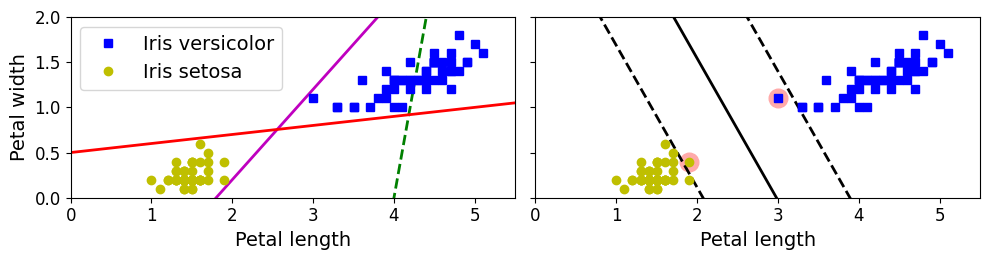

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# 왼쪽 그림
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

# 오른쪽 그림
plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

#### 그림 5-2 코드 (p. 206)

아래 코드는 SVM이 특성 축척에 민감하다는 것을 보여주는 그림을 그려준다.

* 학습 데이터: 작위적으로 지정된 데이터 네 개 (특성 수는 2)
* 왼편 그림: 축척 조정 없음
* 오른편 그림: 축척 조정 전처리 추가

그림 저장: sensitivity_to_feature_scales_plot


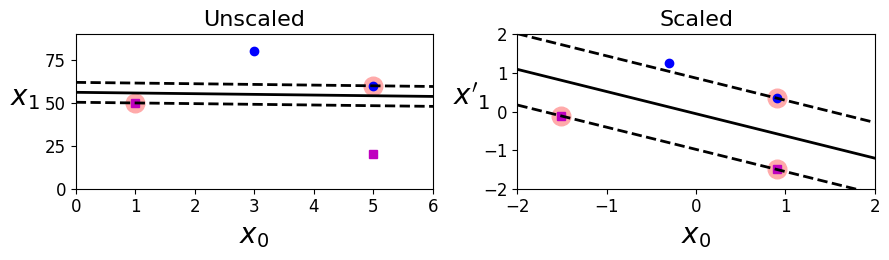

In [5]:
# 학습 데이터 4개
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])

# SVM 훈련
svm_clf = SVC(kernel="linear", C=100)   # 마진 조금 허용
svm_clf.fit(Xs, ys)

# 왼편 그림
plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

# 오른편 그림(축척 조정 전처리 사용)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")

### 5.1.1 소프트 마진 분류 (p.206)

#### 그림 5-3 코드 (p. 207)

아래 코드는 그림 5-1에서 사용한 붓꽃 데이터에 이상치 두 개를 추가할 때 SVM을 이용한 하드 마진 분류의 문제를 보여준다.

* 왼편 그림에 사용된 이상치의 꽃잎 길이/너비 특성: `[3.4, 1.3]`
* 오른편 그림에 사용된 이상치의 꽃잎 길이/너비 특성: `[3.2, 0.8]`

In [6]:
# 이상치 두 개
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])

# 왼편 그림 훈련 세트
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)

# 오른편 그림 훈련 세트
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

그림 저장: sensitivity_to_outliers_plot


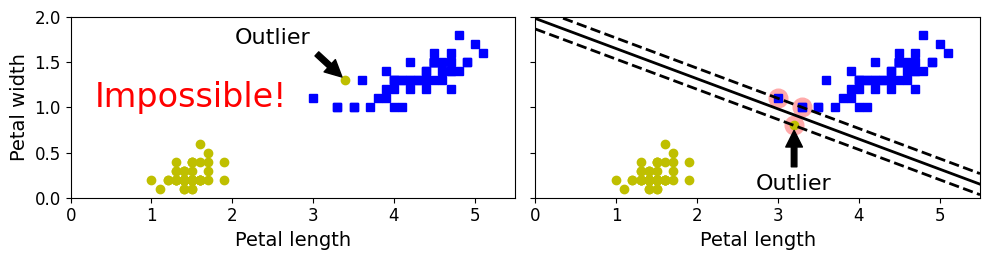

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# 왼편 그림: 하드 마진 분류 불가능
plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

# 오른편 그림: 좋지 않은 하드 마진 분류. SVC와 linear 커널 사용.
svm_clf2 = SVC(kernel="linear", C=10**9)     # 마진 매우 작게 설정
svm_clf2.fit(Xo2, yo2)

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

#### 선형 소프트 마진 분류 학습

아래 코드는 마진 오류를 허용하는, 즉 __소프트 마진 분류__를 지원하는 선형 SVM 학습법을 보여준다. 

* `LinearSVC`: 선형 SVM 이진 분류 모델. 
    - `C=1`: 기본값
    - `logss=hinge`: hinge 손실함수 사용. 기본값은 `squared_hinge`, hinge 손실함수의 제곱이며 미분가능.
    - `dual=True`: 쌍대성(duality) 이용 여부. True가 기본. 하지만 특성 수가 샘플 수보다 작을 때는 False 권장.
* 훈련 세트: 붓꽃 데이터 전체
* 타깃: 버지니카 품종 여부 (음성 0, 양성 1)
* 표준화 축척 조정 전처리 사용

__주의사항:__ `LinearSVC` 모델의 `C`에 의한 규제에 편향(절편)도 포함된다.
따라서 평균을 빼서 0으로 편향을 없애는 것이 중요하다. 
하지만 표준화 축척 조정을 하면 자연스럽게 해결된다.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]                   # 특성: 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # 타깃: 버지니카(Iris-Verginica) 품종 여부

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

/Users/kjs/miniconda3/envs/handson_ml/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

`[5.5, 1.7]` 특성을 갖는 붓꽃에 대한 예측은 양성, 즉 버지니카 품종이다.

In [9]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

#### 그림 5-4 코드 (p. 207)

아래 코드는 소프트 마진 분류에 사용되는 규제(`C`)의 역할을 보여주는 그림을 그린다. 
규제 `C`에 선형적으로 반비례하여 규제 강도가 정해진다. 
`C=float("inf")`, 즉 무한대이면 마진을 전혀 허용하지 않는 하드 마진 분류 모델이 된다.

- `svm_clf1`: `C=1`, 즉 다소 많은 마진 오류 허용. 도로폭 큼. 규제는 강함.
- `svm_clf2`: `C=100`, 보다 적은 마진 오류 허용. 도로폭 보다 좁아짐. 규제는 보다 약함.

In [10]:
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)     # C=1
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)   # C=100

# 축척 조정 전처리 사용
scaler = StandardScaler()

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])

scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

# 훈련
scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/Users/kjs/miniconda3/envs/handson_ml/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/kjs/miniconda3/envs/handson_ml/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/kjs/miniconda3/envs/handson_ml/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

&#x270b; __참고: 원시 데이터(raw data)의 결정경계__

훈련을 통해 학습된 결정경계의 파라미터는 모두 표준화된 값들을 대상으로 하였기 때문에
원시 데이터에 대한 결정경계 도로와 서포트 벡터를 그림으로 표시하려면 표준화 과정을 되돌리는 값을
사용해야 한다.

$\mathbf{x}$를 원시 데이터(raw data) 벡터라고 하고 $\mathbf{z}$를 표준화된 벡터이라 할 때 다음 관계가 성립한다. 

$$
\mathbf{z} = \frac{\mathbf{x}-\mu}{\sigma} \tag{*}
$$

* $\mu$: 평균값(mean)
* $\sigma$: 표준편차(standard deviation)

훈련된 `LinearSVC` 모델의 결정경계 함수(decision function)는 아래 선형함수이다.

$$
h(\mathbf{z}) = w_1 z_1 + \cdots + w_n z_n + b
$$

원시 데이터 $\mathbf{x}$에 대한 결정경계 또한 위 결정경계 함수에 의존하도록 해야 한다. 
$\mathbf{x}$와 결정경계 함수와의 관계를 확인하기 위해 위 식에 $(*)$ 를 대입하여
$x_i$와 결정경계 함수 사이의 관계를 확인한다.

$$
\begin{align*}
w_1 z_1 + \cdots + w_n z_n + b &= w_1 \frac{x_1-\mu}{\sigma} + \cdots + w_n \frac{x_n-\mu}{\sigma} + b \\
&= \frac{w_1}{\sigma} x_1 + \cdots + \frac{w_n}{\sigma} x_n + \left (w_1 \left (-\frac{\mu}{\sigma}\right) + \cdots + w_n \left (-\frac{\mu}{\sigma}\right) + b\right) \\
&= \frac{w_1}{\sigma} x_1 + \cdots + \frac{w_n}{\sigma} x_n + h (-\mu / \sigma)
\end{align*}
$$

결론적으로, 원시 데이터의 각 특성 $x_i$에 대한 파라미터 $w'_i$와 편항 $b'$은 아래와 같다.

$$
\begin{align*}
w'_i & = w_i/\sigma \\[1ex]
b' & = h (-\mu / \sigma)
\end{align*}
$$

참고: https://github.com/ageron/handson-ml/issues/250

아래 코드는 위 설명을 반영하여 원시 데이터에 대한 결정경계 함수의 파라미터와 편향을 계산한다. 
코드에 사용된 객체의 속성은 다음과 같다.

* 'LinearSVC.coef_[0]' 속성: 학습된 파라미터 벡터 $\mathbf{w}$ 저장
* 'LinearSVC.decision_function()' 메서드: 결정 함수 
* 'StandardScaler.mean_' 속성: 원시 데이터의 평균값 저장
* 'StandardScaler.scale_' 속성: 원시 데이터의 표준편차 저장

In [11]:
# 축척이 조정되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])  # 절편
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])  # 절편
w1 = svm_clf1.coef_[0] / scaler.scale_                            # 기울기 파라미터
w2 = svm_clf2.coef_[0] / scaler.scale_                            # 기울기 파라미터

# 새로운 파라미터와 편향 지정
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기: libsvm과 달리 liblinear 라이브러리에서 제공되지 않기에 직접 넣어줌.
# 부울 인덱싱을 이용하여 결정경계 도로 안에 위치한 값들을 서포트 벡터로 지정함.
t = y * 2 - 1                                               # +1, -1 값
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()   # 결정경계 +- 1 안에 있는 데이터
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()   # 결정경계 +- 1 안에 있는 데이터
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

`plot_svc_decision_boundary()` 함수를 이용하여 `C` 값의 영향력을 보여주는 그림을 그린다.

* 왼편 그림: `C=1` 일 때.
* 오른편 그림: `C=100` 일 때.

그림 저장: regularization_plot


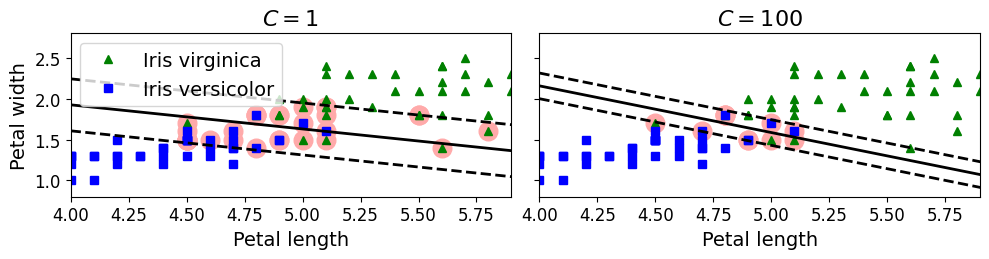

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# 왼편 그림: svm_clf1 모델
plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

# 오른편 그림: svm_clf2 모델
plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

#### `LinearSVC`와 유사한 모델

* SVC 모델: `linear` 커널 사용.

    ```python
    SVC(kernel="linear", C=1)
    ```

* SGDClassifier 모델: `hinge` 손실함수 사용. 일반적인 경사 하강법 적용. 데이터셋이 크거나 온라인 학습에 유용.

    ```python
    SGDClassifier(loss="hinge", alpha=1/(m*C))
    ```

## 5.2 비선형 SVM 분류 (p. 209)

__참고:__ 비선형 분류를 지원하는 SVM 모델은 사이킷런의 `SVC` 클래스이며, `LinearSVC` 클래스는 선형 분류만 지원한다. 

### 다항 특성과 선형 SVM: 아이디어 소개(p. 209)

다항 특성을 추가하여 비선형 회귀문제를 선형 회귀로 해결하는 방식을 4장에서 살펴 보았다.
동일한 아이디어로 선형 SVM 분류기를 비선형 SVM 분류 모델로 훈련시키는 것을 보여준다.

#### 그림 5-5 코드 (p. 209)

아래 코드는 2차 다항 특성을 추가할 경우 비선형 분류 문제를 선형 분류로 해결할 수 있음을 보여주는
그림을 그린다.

* 왼편 그래프: 선형 분류 불가능
* 오른편 그래프: 2차 다항 특성을 추가한 결과 선형 분류 가능해짐

In [13]:
# -4에서 4 사이의 9개의 점 활용: 원래 한 개의 특성만 사용
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)

# 2차 다항 특성 추가
X2D = np.c_[X1D, X1D**2]

# 타깃: 원점에 가까운 5개 데이터만 양성
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

그림 저장: higher_dimensions_plot


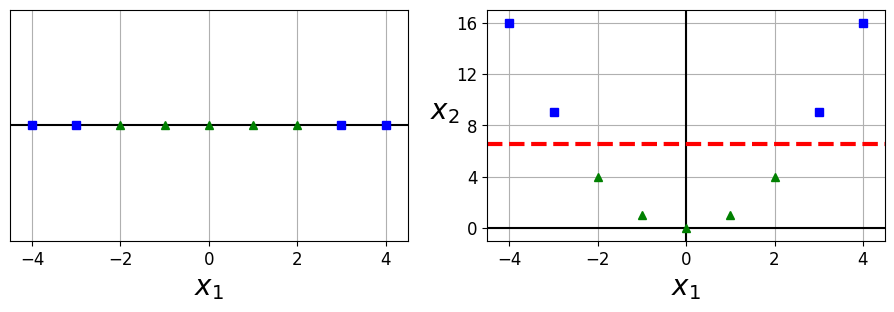

In [14]:
plt.figure(figsize=(10, 3))

# 왼편 그래프
plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")          # 파랑 네모
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")          # 초록 세모
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

# 오른편 그래프
plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")       # 파랑 네모
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")       # 초록 세모
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)  # 빨강 실선
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

#### 그림 5-6 코드 (p. 210)

아래 코드는 moons 데이터셋을 불러온다. 
moons 데이터셋은 지정된 수의 데이터가 선형 분류가 불가능한 두 개의 반달 모양으로 구분되어 있다.

In [15]:
# 100개의 샘플로 구성된 moons 데이터셋 준비
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

`X`는 x, y 좌표로 구성된 100개의 데이터를 담는다.

In [16]:
X.shape

(100, 2)

`y`는 100개 샘플의 레이블을 담고 있다.

In [17]:
y.shape

(100,)

아래 함수는 moons 데이터셋을 색깔과 모양으로 구분한 산점도를 그린다.

In [18]:
# 산점도 그리기 함수
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")   # 파랑 네모: 음성 데이터
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")   # 초록 세모: 양성 데이터
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

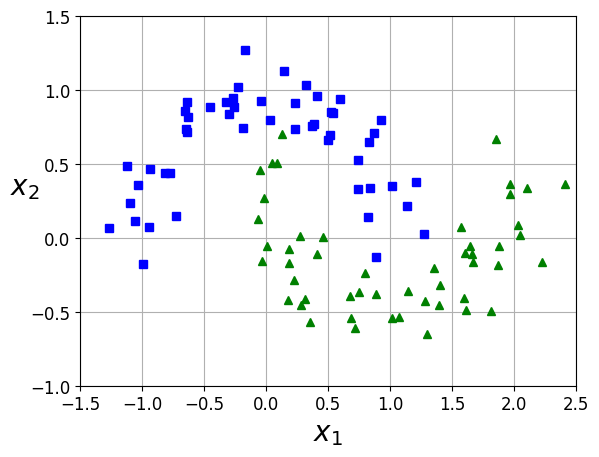

In [19]:
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

아래 코드는 3차 다항 특성을 추가할 경우 moons 데이터셋을 선형 분류로 해결할 수 있음을 보여주는
그림을 그린다.

* `PolynomialFeatures(degree=3)`: 3차 다항 특성까지 추가

In [20]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

/Users/kjs/miniconda3/envs/handson_ml/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/kjs/miniconda3/envs/handson_ml/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

아래 함수는 훈련된 SVM 모델의 결정경계를 그려준다.

In [21]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)       # 결정경계 그리기
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)   # 등고선 그리기

3차 다항 특성을 추가하여 훈련된 SVM 분류기의 성능을 아래 그림이 확인시켜 준다.

그림 저장: moons_polynomial_svc_plot


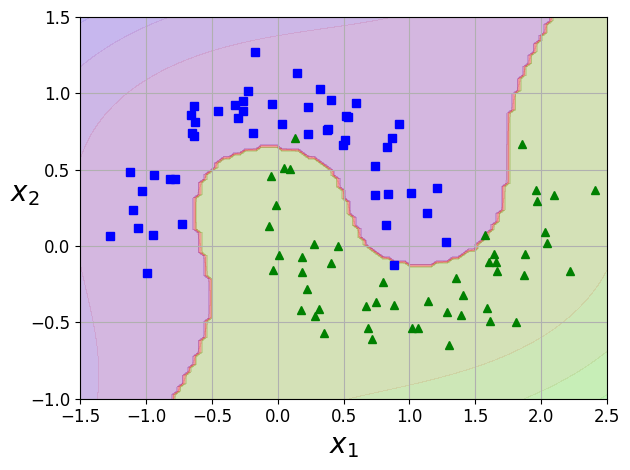

In [22]:
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

### 5.2.1 다항 커널 (p. 211)

다항 특성 추가 기법은 모든 선형 회귀/분류 모델과 함께 사용할 수 있다.
하지만 다항 특성을 추가해서 훈련하는 비용이 경우에 따라 매우 비쌀 수 있다.

그런데 SVM의 경우 __커널 트릭__(kernel trick)을 사용하면 실제로는 특성을 추가하지 않지만
특성을 추가한 효과를 얻을 수 있다. 
`SVC` 모델의 경우 `poly` 커널과 적절한 다항 차수(degree)를 지정하면 
해당 차수만큼의 다항 특성을 추가한 효과를 낸다.

예를 들어 아래 코드는 3차와 10차 다항 특성을 추가한 효과를 이용하여 moons 데이터셋을 분류한 
결과를 그림으로 보여준다.

* 표준화 축척 조정 적용
* `kernel=poly`: 다항 커널 선택
* 다항 특성
    - 왼편: `degree=3` 
    - 오른편: `degree=10` 
* `coef0`: 식 5-10(p.  225)의 $r$에 해당하는 값이며, 값에 비례하여 추가되는 고차항의 영향력이 세짐. 기본값은 0.
    - 왼편: `coef0=1`
    - 오른편: `coef0=100`
* `C=5`: 마진 허용 정도

In [23]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))  # 3차 다항 커널 활용
    ])
poly_kernel_svm_clf.fit(X, y)

# 10차 다항 커널 활용

poly10_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly10_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

`plot_predictions()` 함수를 활용하여 두 개의 그래프를 그린다.

그림 저장: moons_kernelized_polynomial_svc_plot


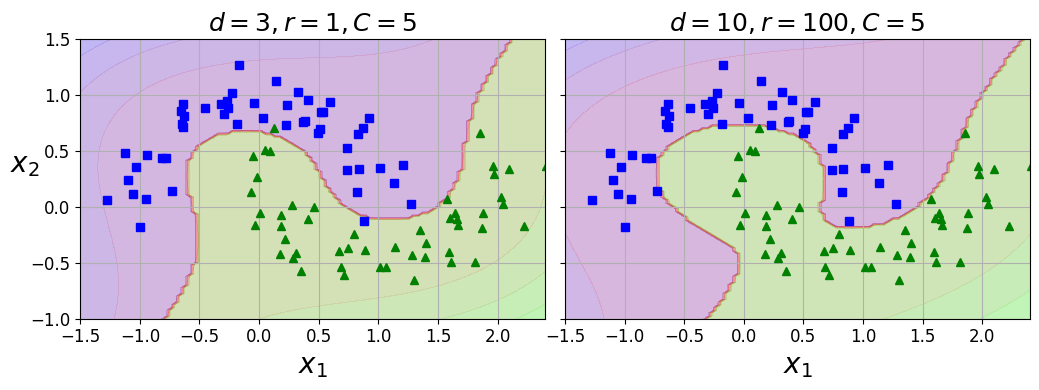

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

# 왼편 그림
plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

# 오른편 그림
plt.sca(axes[1])
plot_predictions(poly10_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

### 5.2.2 유사도 특성: 아이디어 소개 (p. 212)

유사도 특성을 추가하여 고차원 데이터셋을 생성한 후 선형분류를 시도한다.
추가되는 유사도 특성은 사용되는 랜드마크 수에 의존한다.

* 유사도 특성(similarity feature): __랜드마크__(landmark)라 불리는 특정 샘플과 각 샘플 사이의 유사도(유사성 정도)로 이루어지 특성

* 유사도 함수(similarity function): 유사도 측정 함수 
    * 예제: 방사 기저 함수(radial basis function, RBF)

#### 가우시안 RBF(식 5-1)

랜드마크 $\ell$(엘)과 샘플 $\mathbf{x}$ 사이의 유사도를 아래 함수값으로 계산한다.
$\gamma$ 값이 클수록 가까운 샘플을 선호하게 되어 즉 샘플들 사이의 영향을 보다 적게 고려한다.
따라서 모델의 자유도를 높이게 되어 과대적합 위험이 커진다.

$$
{\displaystyle \phi_{\gamma}(\mathbf{x}, \boldsymbol{\ell})} = {\displaystyle \exp({\displaystyle -\gamma \left\| \mathbf{x} - \boldsymbol{\ell} \right\|^2})}
$$

In [25]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

#### 그림 5-8 코드 (p. 213)

아래 코드는 앞서 그림 5.5 코드에서 소개한 선형적으로 구분할 수 없었던 데이터셋(`X1D`)을 가우시안 RBF 함수를 적용하여 선형적으로 구분할 수 있음을 보여준다. 

코드에 사용된 랜드마크는 -2와 1 두 개이며, 따라서 2개의 유사도 특성이 데이터셋에 추가된다.

* `gamma=0.3`: $\gamma$ 값.

In [26]:
gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)

# 왼편 그림에 사용되는 유사도 특성 2개: 방사 기저 함수의 그래프 그리기
x2s = gaussian_rbf(x1s, -2, gamma)   # 랜드마크 -2와의 유사도 특성
x3s = gaussian_rbf(x1s, 1, gamma)    # 랜드마크 1과의 유사도 특성

# 오른편 그림에 사용되는 2개의 유사도 특성. 원시 특성 X1D의 유사도 특성이지만 그림에는 표시하지 않음.
XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

예를 들어, `x=-1`과 두 개의 랜드마크 사이의 유사도는 다음과 같다.

In [27]:
x1_example = X1D[3, 0]   # -1

for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


아래 그림에서 $\mathbf{x}$로 표기된 점이 `x=-1`에 해당한다.

그림 저장: kernel_method_plot


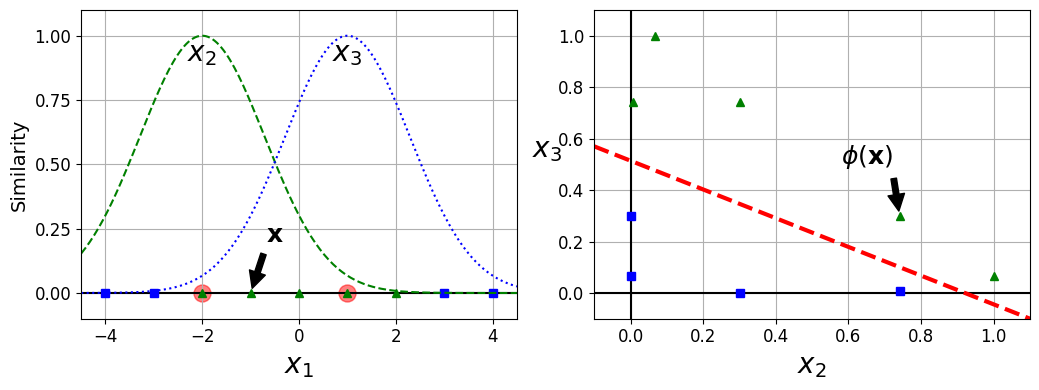

In [28]:
plt.figure(figsize=(10.5, 4))

# 왼편 그림: 종 모양 방사 기저 함수 그래프
plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

# 오른편 그림: 원시 데이터셋 X1D를 이용한 두 개의 유사도 특성을 이용하여 선형 분류 가능함을 보여줌.
plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

### 5.2.3 가우시안 RBF 커널 (p. 213)

모든 샘플을 랜드마크로 지정하는 것이 가장 간단하다.
그런데 이렇게 하면 특성 수가 샘플 수 $m$만큼 늘어난다. 
따라서 훈련 세트가 매우 클 경우 매우 많은 특성이 생겨난다. 

하지만 RBF 커널을 이용하면 다항 커널의 경우처럼 유사도 특성을 실제로는 추가하지 않지만
추가한 효과를 내게 할 수 있다. 
사용법은 `kernel="rbf"`와 적절한 `gamma` 하이퍼파라미터 값을 지정하면 된다.

#### 그림 5-9 코드 (p. 214)

아래 코드는 `gamma`와 `C`의 조합 네 경우를 그림으로 보여준다. 

그림 저장: moons_rbf_svc_plot


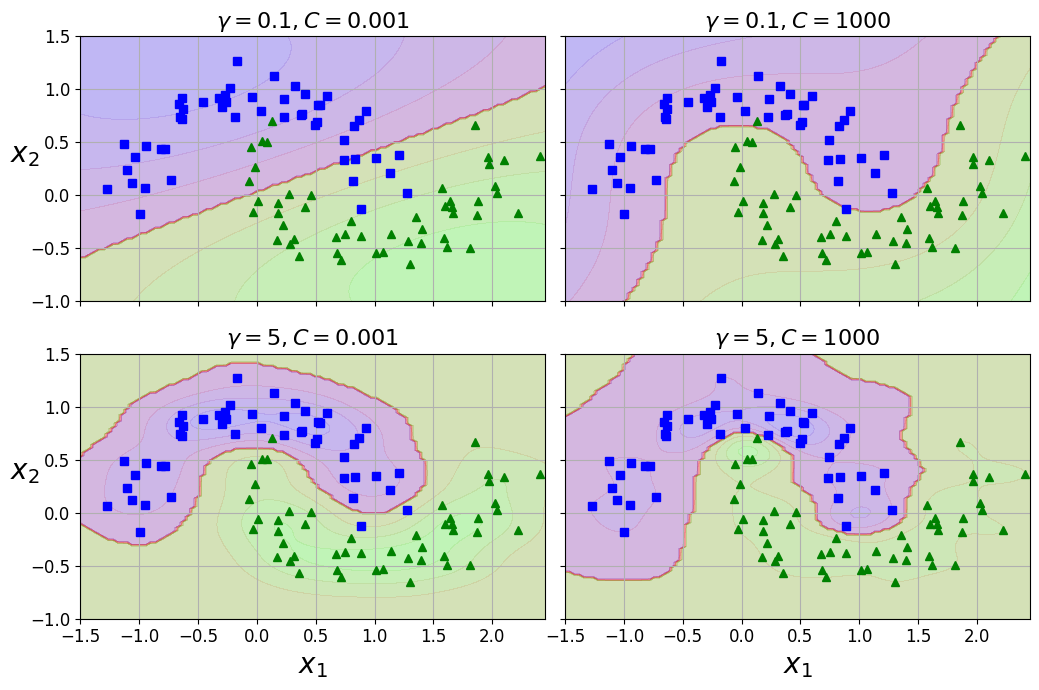

In [29]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)  # gamma와 C의 조합 4 가지

# RBF 커널 사용 SVC 모델 4 개 리스트
svm_clfs = []   
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

# 그림 그리기
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

## 5.3 SVM 회귀 (p. 216)

#### 그림 5-10 코드 (p. 216)

아래 코드는 선형 SVM 회귀를 설명하기 위해 선형 회귀 학습이 가능한 50개의 샘플을 잡음을 섞어 생성한다.

In [30]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

두 개의 `LinearSVR` 모델을 훈련시킨다.

* `epsilon=1.5`/`epsilon=0.5`: 결정 도로의 폭 지정. 기본값은 0.
* `C=1`: 마진 오류 허용 정도. 기본값은 1이며 규제 세기는 `C` 크기에 반 비례.

In [31]:
from sklearn.svm import LinearSVR

svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

/Users/kjs/miniconda3/envs/handson_ml/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/kjs/miniconda3/envs/handson_ml/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVR(epsilon=0.5, random_state=42)

`find_support_vectors()` 함수는 마진 오류 샘플들의 인덱스를 찾는다.

In [32]:
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

# 두 `LinearSVR` 회귀 모델의 마진 오류
svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

# 경계도로 폭(epsilon)을 보여주기 위한 좌표 지정
eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

`plot_svm_regression()` 함수는 SVM 회귀 결과를 결정경계와 함께 그림으로 그려준다. 
사용된 인자는 다음과 같다.

* `svm_reg`: 훈련된 `LinearSVR` 모델
* `X`, `y`: 데이터셋(특성과 타깃)
* `axes`: x/y 축 구간 지정

In [33]:
def plot_svm_regression(svm_reg, X, y, axes):
    # 결정경계 선과 도로 경계 그리기
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")   # 결정경계 선 (검은 실선)
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")                 # 위쪽 도로 경계 (검은 파선)
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")                 # 아랫쪽 도로 경계 (검은 파선)
    
    # X 데이터셋의 샘플 중에서 마진 오류 샘플 표시하기 (분홍 원)
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    
    # X, y 데이터셋 표기 (파랑 점)
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

아래 코드는 `epsilon`을 달리하는 두 `LinearSVR` 모델의 훈련 결과를 보여준다.

그림 저장: svm_regression_plot


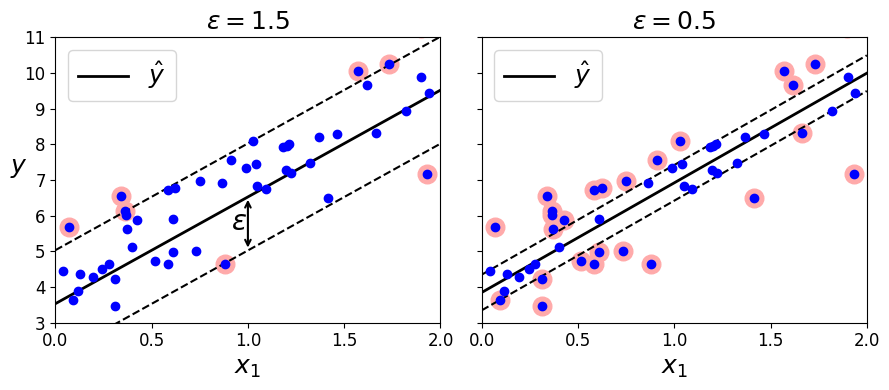

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)

# 왼편 그림
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)

# x1=1을 이용하여 결정경계 도로 폭(epsilon) 위아래 화살표로 표시하기
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)

# 오른편 그림
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

#### 그림 5-11 코드 (p. 217)

아래 코드는 다중 커널을 이용하는 비선형 SVM 회귀를 설명하기 위해 
100개의 샘플을 2차 다항식과 잡음을 이용하여 생성한다.

In [35]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

**참고:** 사이킷런 최신 버전에서 `gamma="scale"`이 기본값이다. 
그러면 `gamma`가 아래 값으로 자동 지정된다.

$$
\frac{1}{\text{특성 수} \cdot \text{특성의 분산}}
$$

2차 다항 커널을 사용하는 두 개의 `SVR` 모델을 훈련시킨다. `C` 규제를 달리한다.

* `kernel=poly`: 다항 커널
* `degree=2`: 2차 다항식 추가(효과)
* `epsilon=0.1`: 결정 도로. 조금 작게.
* `C=100`/`C=0.01`: 마진 오류 허용 정도가 다름.

In [36]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

아래 코드는 마진 오류 허용 정도 `C`를 달리하며 2차 다항 커널을 사용하는 두 `SVR` 모델의 훈련 결과를 보여준다.

| 왼편 그래프(C=100)    | 오른편 그래프(C=0.01)    |
| -------------: | -------------: |
| 규제 보다 약함 | 규제 보다 강함 |
| 샘플에 덜 민감 | 샘플에 더 민감 |
| 마진 오류 보다 적게 | 마진 오류 보다 많이  |

그림 저장: svm_with_polynomial_kernel_plot


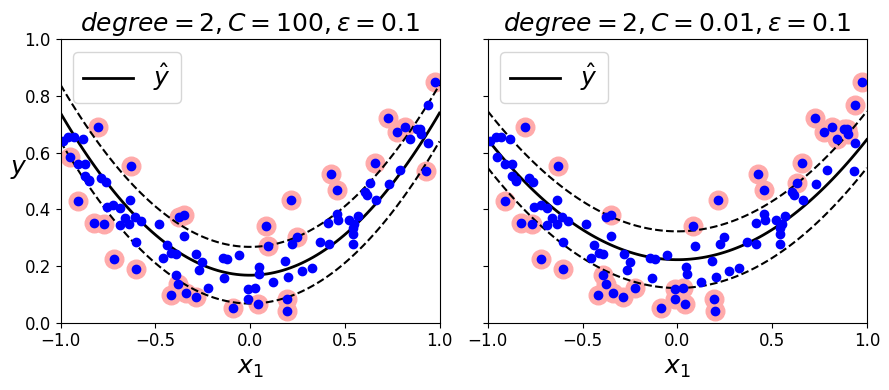

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)

# 왼편 그림: C=100
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)

# 오른편 그림: C=0.01
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

## &#x270b; 5.4 SVM 이론 (p. 218)

여기서는 책에서 이론 설명을 위해 사용되는 그림을 그리는 코드만 제공된다.

__주의사항:__ SVM 이론을 설명할 때 편의상 
파라미터를 $\theta_0, \dots, \theta_n$ 대신에 절편과 특성 파라미터 벡터를
아래처럼 분리해서 사용한다.

$$
\begin{align*}
b &= \theta_0 \\
w_i &= \theta_i \quad (i = 1, \dots, n)
\end{align*}
$$

#### 그림 5-12 코드 (p. 219)

아래 코드는 버지니카 품종 여부 판정을 위해 훈련시킨 선형 SVM 분류 모델을 보여준다.

- 결정경계(검정 실선): 결정 함수값이 0이 되도록 하는 샘플들의 집합
- 결정 도로 경계(검정 파선): 결정 함수값이 $\pm$1이 되도록 하는 샘플들의 집합

In [38]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # 버지니카 품종 여부

TypeError: The first argument to axis() must be an iterable of the form [xmin, xmax, ymin, ymax, zmin, zmax]

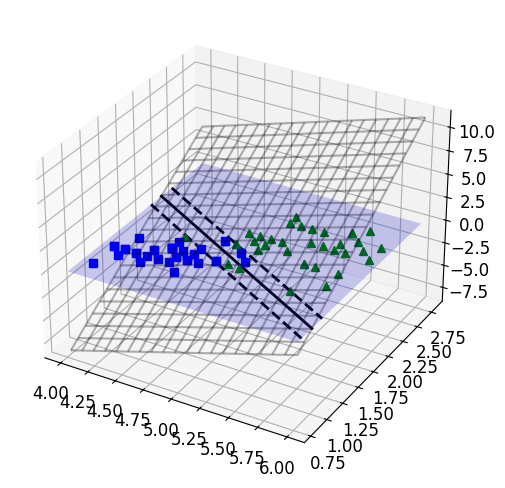

In [39]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

save_fig("iris_3D_plot")
plt.show()

#### 그림 5-13 코드 (p. 220)

아래 코드는 SVM의 목적함수를 설명하는 그림을 그린다.

그림 저장: small_w_large_margin_plot


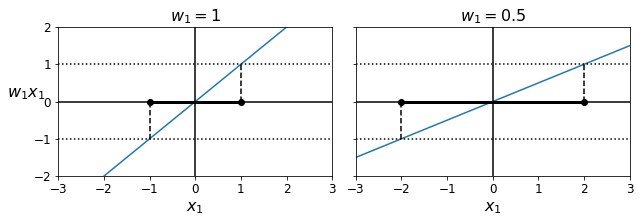

In [40]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

#### 힌지 손실 함수 그래프 코드 (p. 227)

아래 코드는 힌지 손실 함수의 그래프를 그린다.

그림 저장: hinge_plot


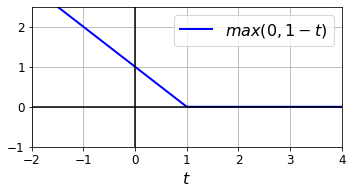

In [41]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
save_fig("hinge_plot")
plt.show()

## &#x1f511; 부록 A: 훈련 시간 측정

moons 데이터셋을 이용한 이진분류 모델을 이용하여
모델의 훈련시간을 간단하게 측정하는 방법을 소개한다.

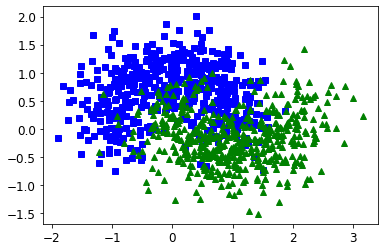

In [42]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

아래 코드는 `tol`(조기종료 조건)을 변경할 때마다 훈련 시간을 측정한 결과를 선 그래프로 보여준다.

[LibSVM]0 0.1 0.18799901008605957
[LibSVM]1 0.01 0.18291831016540527
[LibSVM]2 0.001 0.22299933433532715
[LibSVM]3 0.0001 0.4009850025177002
[LibSVM]4 1e-05 0.6682872772216797
[LibSVM]5 1.0000000000000002e-06 0.6222438812255859
[LibSVM]6 1.0000000000000002e-07 0.666668176651001
[LibSVM]7 1.0000000000000002e-08 0.66237473487854
[LibSVM]8 1.0000000000000003e-09 0.6582813262939453
[LibSVM]9 1.0000000000000003e-10 0.6564273834228516


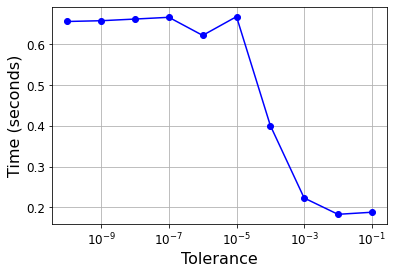

In [43]:
import time

tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10
plt.semilogx(tols, times, "bo-")
plt.xlabel("Tolerance", fontsize=16)
plt.ylabel("Time (seconds)", fontsize=16)
plt.grid(True)
plt.show()

## &#x1f511; 부록 B: 선형 SVM 분류기 구현하기

경사하강법을 이용하여 선형 SVM 분류기를 직접 구현하는 과정을 보여준다.

### 선형 SVM 분류기 클래스 선언

`MyLinearSVC` 클래스를 선언한다.
비용함수는 책 227쪽, 식 5-13에서 소개한 아래 함수이다. 

$$
J(\mathbf{w}, b) = \dfrac{1}{2} \mathbf{w}^T \mathbf{w} \,+\, C {\displaystyle \sum_{i=1}^{m}\max\left(0, 1 - t^{(i)} (\mathbf{w}^T \mathbf{x}^{(i)} + b) \right)}
$$

In [44]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        # 하이퍼파라미터
        self.C = C                            
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    # 학습 스케줄
    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # 파라미터 w와 b를 무작위 초기화하기
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) 
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if t==0, +1 if t==1
        X_t = X * t
        
        # 에포크별 비용 함숫값 저정
        self.Js=[]

        # 훈련
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]
            
            # 비용 함숫값 계산(식 5-13과 다르게 보이지만 서포트 벡터만 다루기에 결국 동일한 값임)
            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -self.C * np.sum(t_sv)
            
            # w, b 업데이트
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])                          # 절편(b) 저장
        self.coef_ = np.array([w])                               # 파라미터 벡터(w) 저장
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()   # 서포트 벡터 인덱스
        self.support_vectors_ = X[support_vectors_idx]           # 서포트 벡터 저장
        return self

    def decision_function(self, X):                              # 결정 함수
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

훈련 세트로 붓꽃 데이터셋을 사용한다. 
버지니카 품종 여부를 판단하는 이진분류 훈련을 진행한다.

In [45]:
# 훈련 세트
X = iris["data"][:, (2, 3)] # # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris virginica

`MyLinearSVC` 모델을 훈련시킨다. (사이킷런의 SVC 모델 보다 좀 많이 느리다.)

In [46]:
svm_clf = MyLinearSVC(C=2, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)

MyLinearSVC(C=2, eta0=10, eta_d=1000, n_epochs=60000, random_state=2)

훈련 과정 중에 비용함숫값의 변화는 다음과 같다.

(0.0, 60000.0, 0.0, 100.0)

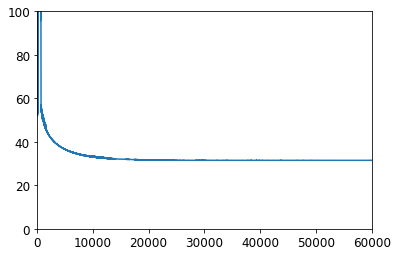

In [47]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

학습된 절편(b)와 특성 파라미터(w)는 다음과 같다.

In [48]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


### 사이킷런의 SVC 모델과의 성능 비교

동일한 데이터셋에 대해 사이킷런의 SVC 모델을 사용한다.
조기종료 조건 `tol=1e-3`이 충족될 때까지 반복 학습함에도 불구하고 학습 속도가 훨씬 빠르다.

In [49]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())               # ravel() 메서드 활용에 주의할 것

SVC(C=1000, kernel='linear')

학습된 w와 b는 매우 이전과 매우 유사하다.

In [50]:
print(svm_clf2.intercept_, svm_clf2.coef_)

[-32.58466933] [[3.99841146 7.99467729]]


실제로 두 모델의 성능을 그래프로 그려보면 다음과 같다.

(4.0, 6.0, 0.8, 2.8)

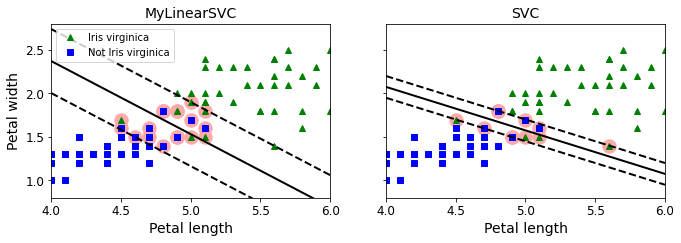

In [51]:
yr = y.ravel()

fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)

# 왼편 그래프
plt.sca(axes[0])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")

# 오른편 그래프
plt.sca(axes[1])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


### SGDClassifier 모델과의 성능 비교

`SGDClassifier` 모델을 SVM 용도로 훈련시키기 위해 힌지 손실 함수를 사용한다. 

In [52]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X, y.ravel())

SGDClassifier(alpha=0.017, random_state=42)

`SGDClassifier` 모델은 원래 SVM 용도로 만들어지지 않았기에 서포트 벡터에 대한 정보를 제공하지 않는다.
아래 코드는 필요한 정보를 구하는 방버을 보여주며 이를 이용하여 결정 경계 도로를 함께 그려준다.

__주의사항:__ 파라미터를 $\theta_0, \dots, \theta_n$으로 사용한다. 즉, 다음이 성립한다.

$$
\begin{align*}
\theta_0 &= b \\
\theta_i &= w_i\quad (i = 1, \dots, n)
\end{align*}
$$

[-12.52988101   1.94162342   1.84544824]


(4.0, 6.0, 0.8, 2.8)

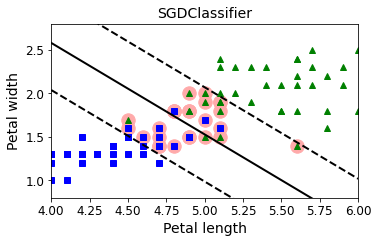

In [53]:
# theta 확인
m = len(X)
t = y * 2 - 1                     # t==0이면 -1, t==1이면 +1
X_b = np.c_[np.ones((m, 1)), X]   # 편향 x0=1 추가.
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)

# 서포트 벡터 관련 정보 확인하기
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]

sgd_clf.C = C

# 그림 그리기
plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

# 연습문제 해답

## 1. to 7.

부록 A 참조.

# 8.

_문제: 선형적으로 분리되는 데이터셋에 `LinearSVC`를 훈련시켜보세요. 그런 다음 같은 데이터셋에 `SVC`와`SGDClassifier`를 적용해보세요. 거의 비슷한 모델이 만들어지는지 확인해보세요._

Iris 데이터셋을 사용하겠습니다. Iris Setosa와 Iris Versicolor 클래스는 선형적으로 구분이 가능합니다.

In [44]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [45]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=1000, tol=1e-3, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28475098] [[1.05364854 1.09903804]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.117] [[0.77714169 0.72981762]]


이 3개 모델의 결정경계를 그려 보겠습니다:

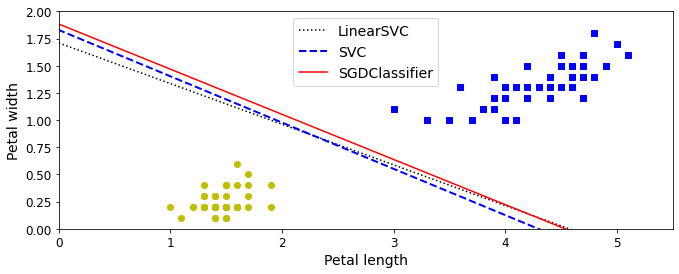

In [46]:
# 각 결정경계의 기울기와 편향을 계산합니다
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# 결정경계를 원본 축척으로 변환합니다
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# 세 개의 결정경계를 모두 그립니다
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

아주 비슷하네요!

# 9.

_문제: MNIST 데이터셋에 SVM 분류기를 훈련시켜보세요. SVM 분류기는 이진 분류기라서 OvA 전략을 사용해 10개의 숫자를 분류해야 합니다. 처리 속도를 높이기 위해 작은 검증 세트로 하이퍼파라미터를 조정하는 것이 좋습니다. 어느 정도까지 정확도를 높일 수 있나요?_

먼저 데이터셋을 로드하고 훈련 세트와 테스트 세트로 나눕니다. `train_test_split()` 함수를 사용할 수 있지만 보통 처음 60,000개의 샘플을 훈련 세트로 사용하고 나머지는 10,000개를 테스트 세트로 사용합니다(이렇게 하면 다른 사람들의 모델과 성능을 비교하기 좋습니다):

In [48]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

많은 훈련 알고리즘은 훈련 샘플의 순서에 민감하므로 먼저 이를 섞는 것이 좋은 습관입니다. 하지만 이 데이터셋은 이미 섞여있으므로 이렇게 할 필요가 없습니다.

선형 SVM 분류기부터 시작해보죠. 이 모델은 자동으로 OvA(또는 OvR) 전략을 사용하므로 특별히 처리해 줄 것이 없습니다. 간단하네요!

**경고**: 이 작업은 하드웨어에 따라 몇 분이 걸릴 수 있습니다.

In [49]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(random_state=42)

훈련 세트에 대한 예측을 만들어 정확도를 측정해 보겠습니다(최종 모델을 선택해 훈련시킨 것이 아니기 때문에 아직 테스트 세트를 사용해서는 안됩니다):

In [50]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.8348666666666666

MNIST에서 89.5% 정확도면 나쁜 성능입니다. 선형 모델이 MNIST 문제에 너무 단순하기 때문이지만 먼저 데이터의 축척을 조정할 필요가 있습니다:

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

**경고**: 이 작업은 하드웨어에 따라 몇 분이 걸릴 수 있습니다.

In [52]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(random_state=42)

In [53]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9217333333333333

훨씬 나아졌지만(에러율을 절반으로 줄였습니다) 여전히 MNIST에서 좋은 성능은 아닙니다. SVM을 사용한다면 커널 함수를 사용해야 합니다. RBF 커널(기본값)로 `SVC`를 적용해 보겠습니다.

**노트**: 향후 버전을 위해 사이킷런 0.22에서 기본값인 `gamma="scale"`을 지정합니다.

In [54]:
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC()

In [55]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9455333333333333

아주 좋네요 6배나 적은 데이터에서 모델을 훈련시켰지만 더 좋은 성능을 얻었습니다. 교차 검증을 사용한 랜덤 서치로 하이퍼파라미터 튜닝을 해보겠습니다. 진행을 빠르게 하기 위해 작은 데이터셋으로 작업하겠습니다:

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....C=5.847490967837556, gamma=0.004375955271336425; total time=   0.4s
[CV] END ....C=5.847490967837556, gamma=0.004375955271336425; total time=   0.4s
[CV] END ....C=5.847490967837556, gamma=0.004375955271336425; total time=   0.3s
[CV] END ....C=2.544266730893301, gamma=0.024987648190235304; total time=   0.3s
[CV] END ....C=2.544266730893301, gamma=0.024987648190235304; total time=   0.3s
[CV] END ....C=2.544266730893301, gamma=0.024987648190235304; total time=   0.3s
[CV] END ....C=2.199505425963898, gamma=0.009340106304825553; total time=   0.3s
[CV] END ....C=2.199505425963898, gamma=0.009340106304825553; total time=   0.3s
[CV] END ....C=2.199505425963898, gamma=0.009340106304825553; total time=   0.3s
[CV] END .....C=7.327377306009368, gamma=0.04329656504133618; total time=   0.3s
[CV] END .....C=7.327377306009368, gamma=0.04329656504133618; total time=   0.3s
[CV] END .....C=7.327377306009368, gamma=0.04329

RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8756c1cc40>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8749d37220>},
                   verbose=2)

In [57]:
rnd_search_cv.best_estimator_

SVC(C=3.8786881587000437, gamma=0.0017076019229344522)

In [58]:
rnd_search_cv.best_score_

0.8599947252641863

이 점수는 낮지만 1,000개의 샘플만 사용한 것을 기억해야 합니다. 전체 데이터셋으로 최선의 모델을 재훈련시켜 보겠습니다:

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 몇 시간이 걸릴 수 있습니다.

In [59]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=3.8786881587000437, gamma=0.0017076019229344522)

In [60]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9978166666666667

아주 훌륭하네요! 이 모델을 선택하겠습니다. 이제 테스트 세트로 모델을 테스트합니다:

In [61]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9717

아주 나쁘지 않지만 확실히 모델이 다소 과대적합되었습니다. 하이퍼파라미터를 조금 더 수정할 수 있지만(가령, `C`와/나 `gamma`를 감소시킵니다) 그렇게 하면 테스트 세트에 과대적합될 위험이 있습니다. 다른 사람들은 하이퍼파라미터 `C=5`와 `gamma=0.005`에서 더 나은 성능(98% 이상의 정확도)을 얻었습니다. 훈련 세트를 더 많이 사용해서 더 오래 랜덤 서치를 수행하면 이런 값을 얻을 수 있을지 모릅니다.

## 10.

_문제: 캘리포니아 주택 가격 데이터셋에 SVM 회귀를 훈련시켜보세요._

사이킷런의 `fetch_california_housing()` 함수를 사용해 데이터셋을 로드합니다:

In [62]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

훈련 세트와 테스트 세트로 나눕니다:

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

데이터의 축척을 조정하는 것을 잊지 마세요:

In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

먼저 간단한 `LinearSVR`을 훈련시켜 보죠:

In [65]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVR(random_state=42)

훈련 세트에 대한 성능을 확인해 보겠습니다:

In [66]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.9641780189948642

RMSE를 확인해 보겠습니다:

In [67]:
np.sqrt(mse)

0.9819256687727764

훈련 세트에서 타깃은 만달러 단위입니다. RMSE는 기대할 수 있는 에러의 정도를 대략 가늠하게 도와줍니다(에러가 클수록 큰 폭으로 증가합니다). 이 모델의 에러가 대략 $10,000 정도로 예상할 수 있습니다. 썩 훌륭하지 않네요. RBF 커널이 더 나을지 확인해 보겠습니다. 하이퍼파라미터 `C`와 `gamma`의 적절한 값을 찾기 위해 교차 검증을 사용한 랜덤 서치를 적용하겠습니다:

In [68]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  12.1s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  12.1s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  12.2s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  11.7s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  11.8s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  12.2s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  11.9s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  11.9s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  12.0s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787431; total time=  11.2s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787431; total time=  11.2s
[CV] END ....C=1.5808361216819946, gamma=0.05399

RandomizedSearchCV(cv=3, estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8749d32160>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8749d32c40>},
                   random_state=42, verbose=2)

In [69]:
rnd_search_cv.best_estimator_

SVR(C=4.745401188473625, gamma=0.07969454818643928)

이제 훈련 세트에서 RMSE를 측정해 보겠습니다:

In [70]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.572752477078535

선형 모델보다 훨씬 나아졌네요. 이 모델을 선택하고 테스트 세트에서 평가해 보겠습니다:

In [71]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.5929168385528767